## Import dependecies and define fuctions

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from scipy.optimize import curve_fit, fsolve
from scipy.interpolate import make_interp_spline, BSpline
from scipy import interpolate

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

# install lmfit regression module
#! pip install lmfit
from lmfit.models import ConstantModel, StepModel
from lmfit import Model, Minimizer, Parameters, report_fit

## Equilibrium fuction

In [2]:
def equilibrium(time_s, elements, errors):
    results = []
    for i, j in zip(elements, errors):
    # assigne x and y values
        x = time_s
        y = df[i].to_numpy()*0.01
        y_err = df[j].to_numpy()*0.01
        #print ("\nelement", i)

        # Equilibrium concentration with 1/3 
        # A : rate_constant, to: onset of the time Ceq:eqilibrium concentraion
        # r =1/3
        r=1/3

        # define power function
        def power(x, A, Ceq):
            return A*(x)**(-r)+Ceq

        # fitting power plot with 2sigma
        popt, pcov = curve_fit(power, x, y, bounds=([-10, 0], [100, 100]), sigma=y_err) 
        #print("Popt:", popt)
        #print("pcov: ", pcov)
        #print("A =", popt[0], "+/-", pcov[0,0]**0.5)
        #print("Ceq =", popt[1], "+/-", pcov[1,1]**0.5)
        results.append((i, "A =", round(popt[0],5), "+/-", round(pcov[0,0]**0.5,5), "Ceq =", round(popt[1],5),"+/-", round(pcov[1,1]**0.5,5)))

    print("\nEquilibrium Concentrations")
    # print stored data of equiilbrium concentration 
    print("Ceq_Al:", results[0][6], "+/-", results[0][8])
    print("Ceq_Cr:", results[1][6], "+/-", results[1][8])
    print("Ceq_Re:", results[2][6], "+/-", results[2][8])
    Ni = 1- results[0][6] - results[1][6] -results[2][6]
    Ni_err = ((results[0][8])**2 + (results[1][8])**2 + (results[2][8])**2)**0.5
    print("Ceq_Ni:", Ni,"+/-", round(Ni_err, 5))

    print("\nList(Al, Cr, Re)")
    eq_conc = [results[0][6], results[1][6], results[2][6]]
    eq_concerr = [results[0][8], results[1][8], results[2][8]]
    print(eq_conc)
    print(eq_concerr)
    return {'eq_conc':eq_conc,'eq_concerr':eq_concerr}

# Gamma prime (L12)

In [3]:
# import csv data
df0= pd.read_csv("C:/Users/jeja9/Bootcamp/APT_analysis/supersaturation\gammaprime_supersaturation700.csv") 
print(f"shape {df0.shape}")
df = df0.iloc[3:8]
df

shape (8, 10)


,time_h,time_s,GP_Ni,GP_Nierr,GP_Al,GP_Alerr,GP_Cr,GP_Crerr,GP_Re,GP_Reerr
3,4.0,14400,74.966523,0.275686,18.480135,0.246471,5.118839,0.138572,1.434502,0.077757
4,16.0,57600,75.171242,0.245344,18.085711,0.218584,5.284353,0.126766,1.458695,0.068854
5,64.0,230400,75.290632,0.105625,18.058158,0.094160,5.339709,0.055114,1.311502,0.028069
6,256.0,921600,75.623223,0.056116,17.820760,0.038521,5.369782,0.023021,1.186236,0.011225
7,1024.0,3686400,75.706626,0.085133,17.771116,0.057481,5.377319,0.035378,1.144939,0.017100


### Extrapolating the equilibrium concentration for Gamma-prime (L12) phase

In [4]:
# Al, Cr, Re equilbrium concentration using for-loop 
#define elements and errors
time_s = df['time_s'].to_numpy()
elements = ['GP_Al', 'GP_Cr', 'GP_Re']
errors = ['GP_Alerr', 'GP_Crerr', 'GP_Reerr']

#calculate the equilibrium composition using fuction equilibrium
eq_concentration = equilibrium(time_s, elements, errors)
eq_concentration


Equilibrium Concentrations
Ceq_Al: 0.17616 +/- 0.00046
Ceq_Cr: 0.05431 +/- 0.00014
Ceq_Re: 0.01069 +/- 0.00032
Ceq_Ni: 0.7588400000000001 +/- 0.00058

List(Al, Cr, Re)
[0.17616, 0.05431, 0.01069]
[0.00046, 0.00014, 0.00032]


{'eq_conc': [0.17616, 0.05431, 0.01069],
 'eq_concerr': [0.00046, 0.00014, 0.00032]}

In [5]:
Al_eq_conc = eq_concentration['eq_conc'][0]
Al_eq_conc

0.17616

## Supersatration and fitting for Al, Cr, Re

In [6]:
# Setup the element, error, and equilibrium concentration list
elements = ['GP_Al', 'GP_Cr', 'GP_Re']
errors = ['GP_Alerr', 'GP_Crerr', 'GP_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

### Define fuction for fitting

In [7]:
# define fuction for fitting for three elements Al, Cr, Re
def fitting_value(x, y, y_err, Ceq):
    
    def power(x, A, r):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([-0.500, 0.00], [0.500, 1.00]), sigma=y_err) 
    print("\nA =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)
    print("r =", round(popt[1], 4), "+/-", pcov[1,1]**0.5)
    A = round(popt[0], 4)
    r = round(popt[1], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(best_fit, y), 4)
    print(f"R_2: {Rsquared}")

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A,'r':r, 'Rsquared':Rsquared, 'xfine':xfine, 'f2':f2 }

In [8]:
# obtain a fitting value for Al, Cr, Re using for-loop
# A : rate constant, r = exponent, Rsqure = fitting accuracy
A_list = []
r_list = []
Rsqured_list = []

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)
    A_list.append(values['A'])
    r_list.append(values['r'])
    Rsqured_list.append(values['Rsquared'])


 GP_Al _eqilibrium:  0.17616

A = 0.2097 +/- 0.1215047718067868
r = 0.3307 +/- 0.04554649047863364
R_2: 0.9527

 GP_Cr _eqilibrium:  0.05431

A = -0.0859 +/- 0.04664491400606295
r = 0.3576 +/- 0.04352843698398683
R_2: 0.9468

 GP_Re _eqilibrium:  0.01069

A = 0.0984 +/- 0.07357318206714633
r = 0.3177 +/- 0.05805950739857927
R_2: 0.7852


In [9]:
# Check the value
print ("Rate_constants [Al, Cr, Re]: ",A_list)
print ("Exponents [Al, Cr, Re]: ",r_list)
print ("Rsqured values [Al, Cr, Re]: ",Rsqured_list)

Rate_constants [Al, Cr, Re]:  [0.2097, -0.0859, 0.0984]
Exponents [Al, Cr, Re]:  [0.3307, 0.3576, 0.3177]
Rsqured values [Al, Cr, Re]:  [0.9527, 0.9468, 0.7852]


In [10]:
print (values['A'])
print (values['r'])
print (values['Rsquared'])
print (values['xfine'])
print (values['f2'])

0.0984
0.3177
0.7852
[9.00000000e+02 1.26858686e+03 1.63717372e+03 ... 3.68566283e+06
 3.68603141e+06 3.68640000e+06]
[0.02202528 0.02085413 0.02006297 ... 0.01149689 0.01149686 0.01149684]


## Plotting the experimental and model values for Al, Cr, Re


 GP_Al _eqilibrium:  0.17616

A = 0.2097 +/- 0.1215047718067868
r = 0.3307 +/- 0.04554649047863364
R_2: 0.9527

 GP_Cr _eqilibrium:  0.05431

A = -0.0859 +/- 0.04664491400606295
r = 0.3576 +/- 0.04352843698398683
R_2: 0.9468

 GP_Re _eqilibrium:  0.01069

A = 0.0984 +/- 0.07357318206714633
r = 0.3177 +/- 0.05805950739857927
R_2: 0.7852


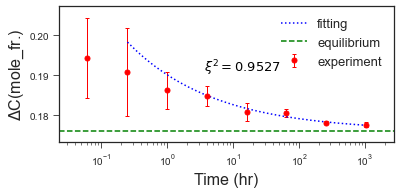

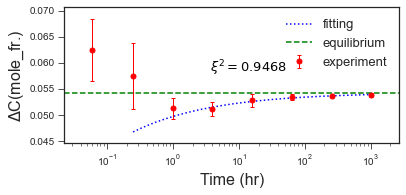

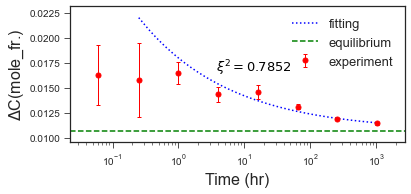

In [11]:
for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)

    #time scale from second to hour
    x0b = x0/3600
    xfineb = values['xfine']/3600
    f2b = values['f2']

    #plotting
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    ax.legend(loc='best', fontsize=13)
    plt.xlabel("Time (hr)", fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    plt.text(0.55, 0.55, r'$\xi^2={}$'.format(values['Rsquared']), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    plt.xscale("log")

    #plt.savefig("test.png")

## Plot with four expoents (r) = 2, 2.4, 3, and 4

In [12]:
## define fuction for fitting_with_r values

def fitting_withr(x, y, y_err, r, Ceq):
    
    def power(x, A):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([-2], [2]), sigma=y_err) 
    print("A =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)

    A = round(popt[0], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(best_fit, y), 4)
    print(f"R_2: {Rsquared}")

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A, 'Rsquared':Rsquared, 'xfine':xfine, 'f2':f2}



 GP_Al _eqilibrium:  0.17616

Exponent value(r):  2
A = 1.5362 +/- 0.2700429838713607
R_2: 0.7641


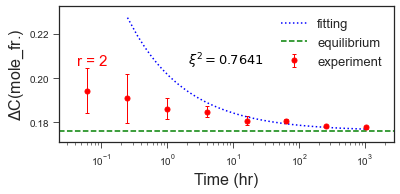


Exponent value(r):  2.4
A = 0.598 +/- 0.062441194665734175
R_2: 0.8569


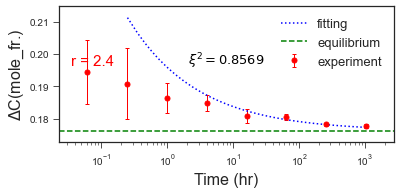


Exponent value(r):  3
A = 0.2167 +/- 0.0147579592457496
R_2: 0.9518


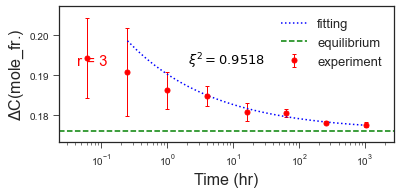


Exponent value(r):  4
A = 0.0738 +/- 0.007094390048563095
R_2: 0.6999


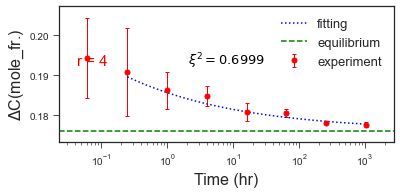



 GP_Cr _eqilibrium:  0.05431

Exponent value(r):  2
A = -0.4515 +/- 0.06528392406940962
R_2: 0.9156


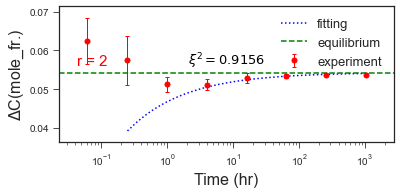


Exponent value(r):  2.4
A = -0.1753 +/- 0.014924367256863127
R_2: 0.964


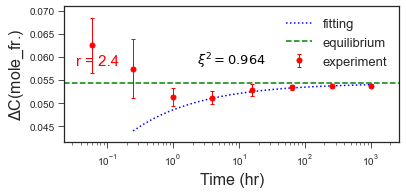


Exponent value(r):  3
A = -0.0635 +/- 0.004488606801984444
R_2: 0.8952


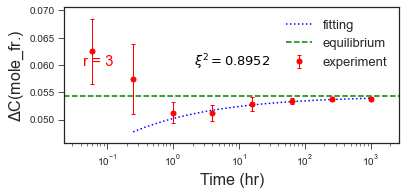


Exponent value(r):  4
A = -0.0217 +/- 0.002391824256199663
R_2: 0.0585


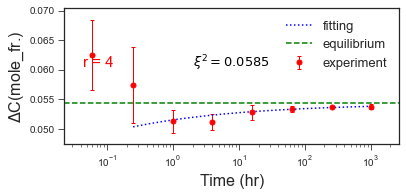



 GP_Re _eqilibrium:  0.01069

Exponent value(r):  2
A = 0.8584 +/- 0.170422424502381
R_2: 0.5656


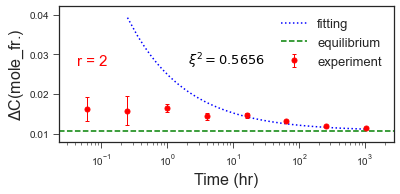


Exponent value(r):  2.4
A = 0.3327 +/- 0.04147700329143545
R_2: 0.6648


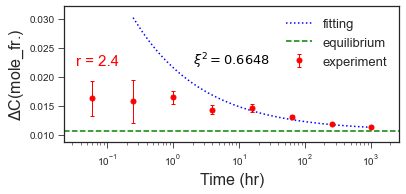


Exponent value(r):  3
A = 0.12 +/- 0.010094760760576131
R_2: 0.7769


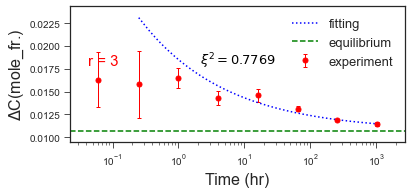


Exponent value(r):  4
A = 0.0407 +/- 0.004100908046523101
R_2: 0.5975


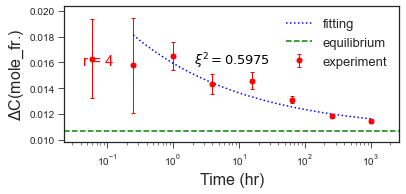

In [13]:
# for different r values ()

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)
    
    for n in [2, 2.4, 3, 4]:
        # print the fitting values
        print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)

        #time scale from second to hour
        x0b = x0/3600
        xfineb = values_wor['xfine']/3600
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        
        #plotting
        fig, ax = plt.subplots(figsize=(6,2.5))
        ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
        ax.plot(xfineb, f2b, 'b:', label=r'fitting')
        ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
        ax.legend(loc='best', fontsize=13)
        plt.xlabel("Time (hr)", fontsize=16)
        plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
        #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
        ax.text(0.1, 0.6, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
        plt.text(0.5, 0.6, r'$\xi^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
        #plt.yscale("log")
        plt.margins(0.1)
        plt.xscale("log")
        plt.show()
        #plt.savefig("test.png")


## Plot with exponent value of aging time



 GP_Al _eqilibrium:  0.17616

Exponent value(r):  2
A = 1.5362 +/- 0.2700429838713607
R_2: 0.7641


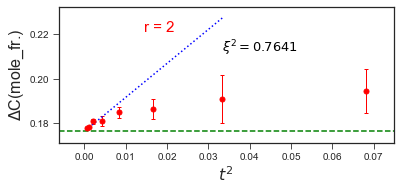


Exponent value(r):  2.4
A = 0.598 +/- 0.062441194665734175
R_2: 0.8569


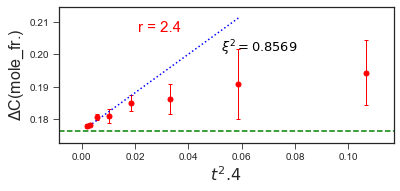


Exponent value(r):  3
A = 0.2167 +/- 0.0147579592457496
R_2: 0.9518


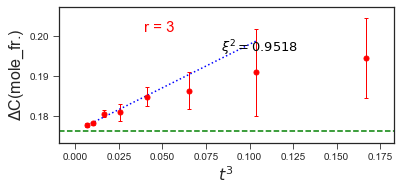


Exponent value(r):  4
A = 0.0738 +/- 0.007094390048563095
R_2: 0.6999


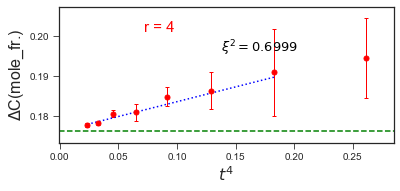



 GP_Cr _eqilibrium:  0.05431

Exponent value(r):  2
A = -0.4515 +/- 0.06528392406940962
R_2: 0.9156


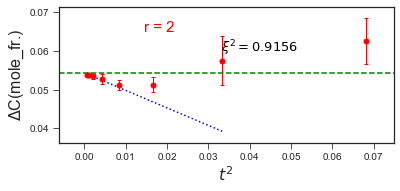


Exponent value(r):  2.4
A = -0.1753 +/- 0.014924367256863127
R_2: 0.964


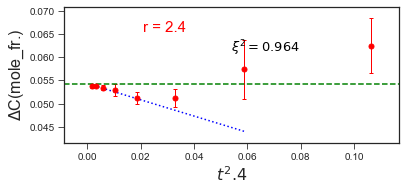


Exponent value(r):  3
A = -0.0635 +/- 0.004488606801984444
R_2: 0.8952


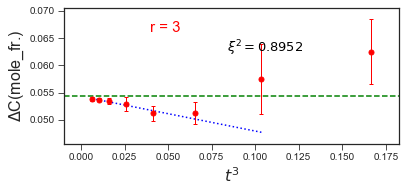


Exponent value(r):  4
A = -0.0217 +/- 0.002391824256199663
R_2: 0.0585


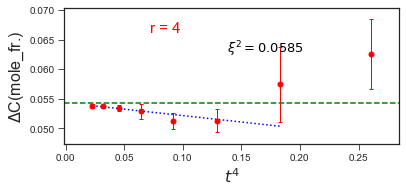



 GP_Re _eqilibrium:  0.01069

Exponent value(r):  2
A = 0.8584 +/- 0.170422424502381
R_2: 0.5656


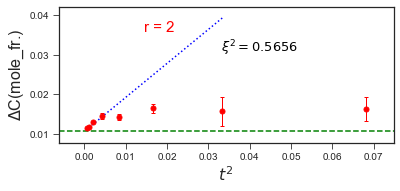


Exponent value(r):  2.4
A = 0.3327 +/- 0.04147700329143545
R_2: 0.6648


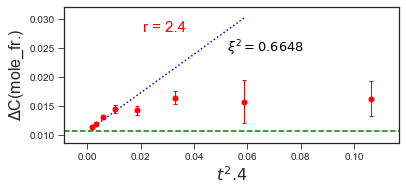


Exponent value(r):  3
A = 0.12 +/- 0.010094760760576131
R_2: 0.7769


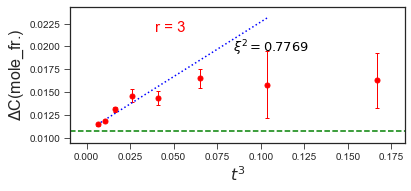


Exponent value(r):  4
A = 0.0407 +/- 0.004100908046523101
R_2: 0.5975


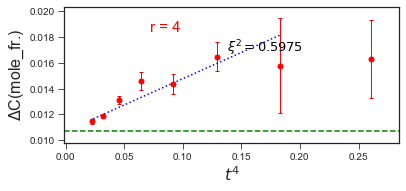

In [14]:
# for different r values ()

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)
    
    for n in [2, 2.4, 3, 4]:
        # print the fitting values
        print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)
        
        #time scale from second to hour
        x0b = x0**(-r)
        xfineb = (values_wor['xfine'])**(-r)
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        
        #plotting
        fig, ax = plt.subplots(figsize=(6,2.5))
        ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
        ax.plot(xfineb, f2b, 'b:', label=r'fitting')
        ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
        plt.xlabel(r'$t^{}$'.format(n), fontsize=16)
        plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
        #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
        ax.text(0.3, 0.85, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
        plt.text(0.6, 0.7, r'$\xi^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
        #plt.yscale("log")
        plt.margins(0.1)
        plt.show()
        #plt.savefig("test.png")


Exponent value(r):  2
A = 1.5362 +/- 0.2700429838713607
R_2: 0.7641

Exponent value(r):  2.4
A = 0.598 +/- 0.062441194665734175
R_2: 0.8569

Exponent value(r):  3
A = 0.2167 +/- 0.0147579592457496
R_2: 0.9518

Exponent value(r):  4
A = 0.0738 +/- 0.007094390048563095
R_2: 0.6999


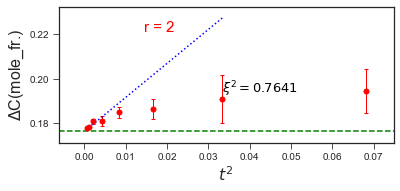

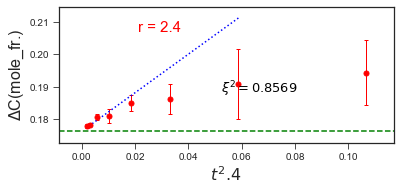

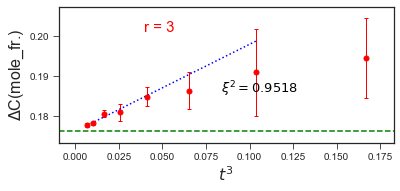

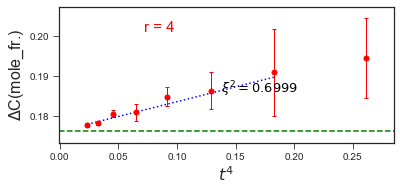

In [15]:
# for different r values ()

# Setup the element, error, and equilibrium concentration list
elements = ['GP_Al', 'GP_Cr', 'GP_Re']
errors = ['GP_Alerr', 'GP_Crerr', 'GP_Reerr']
Al_eq_conc = eq_concentration['eq_conc'][0]

x0 = df0['time_s'].to_numpy()
y0 = df0['GP_Al'].to_numpy()*0.01
y0_err = df0['GP_Alerr'].to_numpy()*0.01
x = df['time_s'].to_numpy()
y = df['GP_Al'].to_numpy()*0.01
y_err = df['GP_Alerr'].to_numpy()*0.01
Ceq = Al_eq_conc


for n in [2, 2.4, 3, 4]:
    # print the fitting values
    print ("\nExponent value(r): ", n)
    r = 1/n
    values_wor = fitting_withr(x, y, y_err, r, Ceq)

    #time scale from second to hour
    x0b = x0**(-r)
    xfineb = (values_wor['xfine'])**(-r)
    f2b = values_wor['f2']
    Rsquared =values_wor['Rsquared']

    #plotting
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    plt.xlabel(r'$t^{}$'.format(n), fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    ax.text(0.3, 0.85, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
    plt.text(0.6, 0.4, r'$\xi^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    
    #plt.savefig("test.png")

In [16]:
# define fuction for fitting for three elements Al, Cr, Re
## define fuction for fitting_with_r values

def fitting_withr(x, y, y_err, r, Ceq):
    
    def power(x, A):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, sigma=y_err) 
    print("A =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)

    A = round(popt[0], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(best_fit, y), 4)
    print(f"R_2: {Rsquared}")

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A, 'Rsquared':Rsquared, 'xfine':xfine, 'f2':f2}

# for different r values ()

elements = ['GP_Al', 'GP_Cr', 'GP_Re']
errors = ['GP_Alerr', 'GP_Crerr', 'GP_Reerr']
Al_eq_conc = eq_concentration['eq_conc'][1]

x0 = df0['time_s'].to_numpy()
y0 = df0['GP_Cr'].to_numpy()*0.01
y0_err = df0['GP_Crerr'].to_numpy()*0.01
x = df['time_s'].to_numpy()
y = df['GP_Cr'].to_numpy()*0.01
y_err = df['GP_Crerr'].to_numpy()*0.01
Ceq = Al_eq_conc

rsq_dict ={}

for n in np.linspace(1.5, 4, 100):
    # print the fitting values
    print ("\nExponent value(r): ", n)
    r = 1/n
    values_wor = fitting_withr(x, y, y_err, r, Ceq)

    #time scale from second to hour
    x0b = x0**(-r)
    xfineb = (values_wor['xfine'])**(-r)
    f2b = values_wor['f2']
    Rsquared =values_wor['Rsquared']
    rsq_dict[n] =values_wor['Rsquared']

print (rsq_dict)


Exponent value(r):  1.5
A = -2.4992 +/- 0.7223397238148619
R_2: 0.8593

Exponent value(r):  1.5252525252525253
A = -2.2443 +/- 0.6271685902636693
R_2: 0.8607

Exponent value(r):  1.5505050505050506
A = -2.0213 +/- 0.5460200711153199
R_2: 0.8622

Exponent value(r):  1.5757575757575757
A = -1.8254 +/- 0.47660006754579815
R_2: 0.864

Exponent value(r):  1.601010101010101
A = -1.6528 +/- 0.41702804772293406
R_2: 0.8659

Exponent value(r):  1.6262626262626263
A = -1.5003 +/- 0.36575560115033917
R_2: 0.868

Exponent value(r):  1.6515151515151516
A = -1.3651 +/- 0.3215023160833897
R_2: 0.8703

Exponent value(r):  1.6767676767676767
A = -1.2449 +/- 0.2832049849678516
R_2: 0.8727

Exponent value(r):  1.702020202020202
A = -1.1378 +/- 0.24997785221661215
R_2: 0.8753

Exponent value(r):  1.7272727272727273
A = -1.042 +/- 0.2210798043490933
R_2: 0.8781

Exponent value(r):  1.7525252525252526
A = -0.9562 +/- 0.19588876212692535
R_2: 0.8811

Exponent value(r):  1.7777777777777777
A = -0.8792 +/- 0.

0.9685
2.5353535353535355
0.3944223107569721


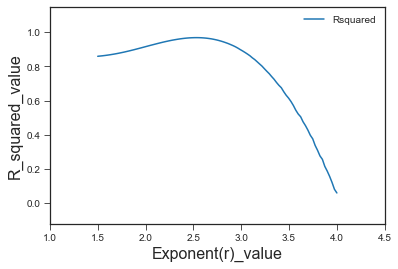

In [17]:
fit_df=pd.DataFrame.from_dict(rsq_dict, orient='index',
                       columns=['Rsquared'])
print(fit_df["Rsquared"].max())
print(fit_df["Rsquared"].idxmax())
print(1/fit_df["Rsquared"].idxmax())
fit_df.plot(y='Rsquared', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "R_squared_value", fontsize=16)
plt.margins(0.2)
plt.show()